In [1]:
import torch
import torch.nn as nn

class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        output = x.div(keep_prob) * random_tensor
        return output

class ConvNeXtBlock(nn.Module):
    def __init__(self, dim, drop_path=0.1):
        super(ConvNeXtBlock, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.conv2d_1 = nn.Conv2d(dim, 4 * dim, kernel_size=1)
        self.gelu = nn.GELU()
        self.conv2d_2 = nn.Conv2d(4 * dim, dim, kernel_size=1)
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv2d_1(x)
        x = self.gelu(x)
        x = self.conv2d_2(x)
        x = input + self.drop_path(x)
        return x
    
class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.norm = nn.LayerNorm(dim, eps=eps)
    def forward(self, x):
        if x.ndim == 2:
            return self.norm(x)
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = x.permute(0, 3, 1, 2)
        return x
    
class DownSample(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(DownSample, self).__init__()
        self.norm = LayerNorm(in_dim)
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size=2, stride=2)
    def forward(self, x):
        x = self.norm(x)
        x = self.conv(x)
        return x

class ConvNeXt(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeXt, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=4, stride=4),
            LayerNorm(96, eps=1e-6)
        )
        self.stage1 = nn.Sequential(
            self._make_stage(96, 3)
        )
        self.stage2 = nn.Sequential(
            DownSample(96, 192),
            self._make_stage(192, 3)
        )
        self.stage3 = nn.Sequential(
            DownSample(192, 384),
            self._make_stage(384, 9),
        )
        self.stage4 = nn.Sequential(
            DownSample(384, 768),
            self._make_stage(768, 3),
        )
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            LayerNorm(768, eps=1e-6),
            nn.Linear(768, num_classes)
        )
    def _make_stage(self, dim, depth):
        layers = []
        for _ in range(depth):
            layers.append(ConvNeXtBlock(dim))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.head(x)
        return x
    
        


🔹 Epoch 1/40


💾 Saved best model (val acc: 61.98%) to '../models/convnextv1.pth'
✅ Epoch 1/40 -- Train Loss: 1.2821, Train Acc: 48.30% | Val Loss: 0.9985, Val Acc: 61.98%

🔹 Epoch 2/40


💾 Saved best model (val acc: 68.37%) to '../models/convnextv1.pth'
✅ Epoch 2/40 -- Train Loss: 1.0430, Train Acc: 58.32% | Val Loss: 0.8351, Val Acc: 68.37%

🔹 Epoch 3/40


✅ Epoch 3/40 -- Train Loss: 0.9142, Train Acc: 64.55% | Val Loss: 0.8088, Val Acc: 67.30%

🔹 Epoch 4/40


💾 Saved best model (val acc: 76.18%) to '../models/convnextv1.pth'
✅ Epoch 4/40 -- Train Loss: 0.8035, Train Acc: 69.20% | Val Loss: 0.6513, Val Acc: 76.18%

🔹 Epoch 5/40


✅ Epoch 5/40 -- Train Loss: 0.7269, Train Acc: 73.19% | Val Loss: 0.6679, Val Acc: 75.61%

🔹 Epoch 6/40


💾 Saved best model (val acc: 77.43%) to '../models/convnextv1.pth'
✅ Epoch 6/40 -- Train Loss: 0.6800, Train Acc: 74.60% | Val Loss: 0.6099, Val Acc: 77.43%

🔹 Epoch 7/40


💾 Saved best model (val acc: 80.49%) to '../models/convnextv1.pth'
✅ Epoch 7/40 -- Train Loss: 0.6324, Train Acc: 76.95% | Val Loss: 0.5427, Val Acc: 80.49%

🔹 Epoch 8/40


💾 Saved best model (val acc: 80.71%) to '../models/convnextv1.pth'
✅ Epoch 8/40 -- Train Loss: 0.5994, Train Acc: 77.78% | Val Loss: 0.5294, Val Acc: 80.71%

🔹 Epoch 9/40


💾 Saved best model (val acc: 82.42%) to '../models/convnextv1.pth'
✅ Epoch 9/40 -- Train Loss: 0.5602, Train Acc: 79.68% | Val Loss: 0.4851, Val Acc: 82.42%

🔹 Epoch 10/40


✅ Epoch 10/40 -- Train Loss: 0.5359, Train Acc: 80.41% | Val Loss: 0.4935, Val Acc: 82.24%

🔹 Epoch 11/40


💾 Saved best model (val acc: 83.49%) to '../models/convnextv1.pth'
✅ Epoch 11/40 -- Train Loss: 0.5120, Train Acc: 81.24% | Val Loss: 0.4555, Val Acc: 83.49%

🔹 Epoch 12/40


✅ Epoch 12/40 -- Train Loss: 0.4830, Train Acc: 82.06% | Val Loss: 0.4687, Val Acc: 82.85%

🔹 Epoch 13/40


💾 Saved best model (val acc: 83.77%) to '../models/convnextv1.pth'
✅ Epoch 13/40 -- Train Loss: 0.4707, Train Acc: 82.76% | Val Loss: 0.4475, Val Acc: 83.77%

🔹 Epoch 14/40


💾 Saved best model (val acc: 84.66%) to '../models/convnextv1.pth'
✅ Epoch 14/40 -- Train Loss: 0.4502, Train Acc: 83.26% | Val Loss: 0.4335, Val Acc: 84.66%

🔹 Epoch 15/40


✅ Epoch 15/40 -- Train Loss: 0.4448, Train Acc: 83.50% | Val Loss: 0.4856, Val Acc: 82.45%

🔹 Epoch 16/40


💾 Saved best model (val acc: 85.49%) to '../models/convnextv1.pth'
✅ Epoch 16/40 -- Train Loss: 0.4269, Train Acc: 84.19% | Val Loss: 0.4144, Val Acc: 85.49%

🔹 Epoch 17/40


✅ Epoch 17/40 -- Train Loss: 0.4146, Train Acc: 84.64% | Val Loss: 0.4447, Val Acc: 84.02%

🔹 Epoch 18/40


💾 Saved best model (val acc: 87.30%) to '../models/convnextv1.pth'
✅ Epoch 18/40 -- Train Loss: 0.4019, Train Acc: 85.33% | Val Loss: 0.3707, Val Acc: 87.30%

🔹 Epoch 19/40


💾 Saved best model (val acc: 87.45%) to '../models/convnextv1.pth'
✅ Epoch 19/40 -- Train Loss: 0.3850, Train Acc: 85.81% | Val Loss: 0.3636, Val Acc: 87.45%

🔹 Epoch 20/40


✅ Epoch 20/40 -- Train Loss: 0.3778, Train Acc: 85.94% | Val Loss: 0.4021, Val Acc: 86.20%

🔹 Epoch 21/40


✅ Epoch 21/40 -- Train Loss: 0.3705, Train Acc: 86.44% | Val Loss: 0.3899, Val Acc: 86.45%

🔹 Epoch 22/40


✅ Epoch 22/40 -- Train Loss: 0.3640, Train Acc: 86.65% | Val Loss: 0.3931, Val Acc: 86.09%

🔹 Epoch 23/40


✅ Epoch 23/40 -- Train Loss: 0.3504, Train Acc: 87.02% | Val Loss: 0.3683, Val Acc: 86.98%

🔹 Epoch 24/40


💾 Saved best model (val acc: 87.80%) to '../models/convnextv1.pth'
✅ Epoch 24/40 -- Train Loss: 0.3434, Train Acc: 87.20% | Val Loss: 0.3572, Val Acc: 87.80%

🔹 Epoch 25/40


💾 Saved best model (val acc: 87.84%) to '../models/convnextv1.pth'
✅ Epoch 25/40 -- Train Loss: 0.3352, Train Acc: 87.78% | Val Loss: 0.3523, Val Acc: 87.84%

🔹 Epoch 26/40


✅ Epoch 26/40 -- Train Loss: 0.3274, Train Acc: 88.10% | Val Loss: 0.3682, Val Acc: 86.31%

🔹 Epoch 27/40


💾 Saved best model (val acc: 88.45%) to '../models/convnextv1.pth'
✅ Epoch 27/40 -- Train Loss: 0.3049, Train Acc: 88.65% | Val Loss: 0.3341, Val Acc: 88.45%

🔹 Epoch 28/40


✅ Epoch 28/40 -- Train Loss: 0.3118, Train Acc: 88.39% | Val Loss: 0.3450, Val Acc: 88.05%

🔹 Epoch 29/40


✅ Epoch 29/40 -- Train Loss: 0.2970, Train Acc: 88.95% | Val Loss: 0.3499, Val Acc: 87.38%

🔹 Epoch 30/40


✅ Epoch 30/40 -- Train Loss: 0.2936, Train Acc: 88.81% | Val Loss: 0.3540, Val Acc: 87.52%

🔹 Epoch 31/40


✅ Epoch 31/40 -- Train Loss: 0.2930, Train Acc: 89.35% | Val Loss: 0.3392, Val Acc: 88.41%

🔹 Epoch 32/40


✅ Epoch 32/40 -- Train Loss: 0.2711, Train Acc: 89.90% | Val Loss: 0.3532, Val Acc: 87.70%

🔹 Epoch 33/40


✅ Epoch 33/40 -- Train Loss: 0.2698, Train Acc: 90.13% | Val Loss: 0.3617, Val Acc: 86.98%

🔹 Epoch 34/40


✅ Epoch 34/40 -- Train Loss: 0.2636, Train Acc: 90.33% | Val Loss: 0.3471, Val Acc: 87.84%

🔹 Epoch 35/40


✅ Epoch 35/40 -- Train Loss: 0.2604, Train Acc: 90.32% | Val Loss: 0.3506, Val Acc: 87.98%

🔹 Epoch 36/40


💾 Saved best model (val acc: 88.55%) to '../models/convnextv1.pth'
✅ Epoch 36/40 -- Train Loss: 0.2559, Train Acc: 90.65% | Val Loss: 0.3384, Val Acc: 88.55%

🔹 Epoch 37/40


💾 Saved best model (val acc: 89.02%) to '../models/convnextv1.pth'
✅ Epoch 37/40 -- Train Loss: 0.2386, Train Acc: 91.21% | Val Loss: 0.3237, Val Acc: 89.02%

🔹 Epoch 38/40


✅ Epoch 38/40 -- Train Loss: 0.2306, Train Acc: 91.72% | Val Loss: 0.3377, Val Acc: 88.87%

🔹 Epoch 39/40


✅ Epoch 39/40 -- Train Loss: 0.2386, Train Acc: 90.87% | Val Loss: 0.3259, Val Acc: 88.91%

🔹 Epoch 40/40


✅ Epoch 40/40 -- Train Loss: 0.2275, Train Acc: 91.56% | Val Loss: 0.3711, Val Acc: 86.84%

🎯 Training complete. Best Val Acc: 89.02%
Test Loss: 0.3335
Test Accuracy: 87.67%

Classification Report:
              precision    recall  f1-score   support

   buildings       0.86      0.87      0.86       437
      forest       0.97      0.98      0.97       474
     glacier       0.88      0.75      0.81       553
    mountain       0.77      0.90      0.83       525
         sea       0.91      0.89      0.90       510
      street       0.90      0.89      0.89       501

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



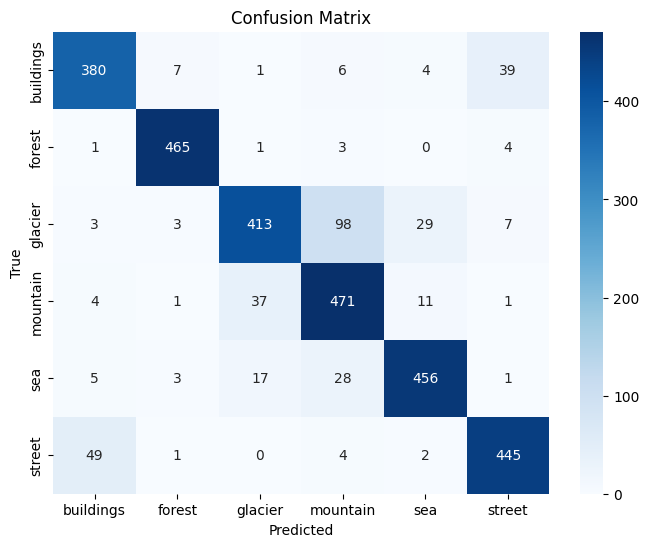

In [3]:
import sys
sys.path.insert(0, '/datastore/cndt_hangdv/music-project/style_transfer/lab04/src')
import importlib
import dataset
import train
importlib.reload(dataset)
importlib.reload(train)
from dataset import loader_dict, dataset_dict
from train import train_model, test_model

device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
convnext = ConvNeXt(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convnext.parameters(), lr=1e-4)
save_path = '../models/convnextv1.pth'
class_names = dataset_dict['train'].class_names
train_model(convnext, loader_dict, dataset_dict, num_epochs=40, criterion=criterion, optimizer=optimizer, device=device, save_path=save_path)
test_model(save_path, convnext, loader_dict['test'], dataset_dict['test'], criterion, device, class_names)
